In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [14]:
def save_plot(filename):
    """Saves the current plot to a 'plots' folder in PDF format."""
    # Create directory if it doesn't exist
    os.makedirs("plots", exist_ok=True)
    
    # Save the file
    path = f"plots/{filename}.pdf"
    plt.savefig(path, format='pdf', bbox_inches='tight')

In [15]:
def load_and_merge():
    try:
        with open("../traces_CA_nf/traces_CA_nf.json", 'r', encoding='utf-8') as f:
            data_nf = json.load(f)
        with open("../traces_CA/traces_CA.json", 'r', encoding='utf-8') as f:
            data_forced = json.load(f)
        with open("../traces_TCA/traces_TCA.json", 'r', encoding='utf-8') as f:
            data_agent = json.load(f)
    except FileNotFoundError as e:
        print(f"Errore: File non trovato. Controlla i percorsi. {e}")
        return pd.DataFrame()

    df_nf = pd.DataFrame(data_nf)
    df_forced = pd.DataFrame(data_forced)
    df_agent = pd.DataFrame(data_agent)

    cols_interest = ['question_id', 'difficulty', 'execution_accuracy', 'pred_query',
                     'latency', 'tool_call_count', 'error_count', 'reasoning_len']
    
    nf_cols = [c for c in cols_interest if c in df_nf.columns]
    forced_cols = [c for c in cols_interest if c in df_forced.columns]
    agent_cols = [c for c in cols_interest if c in df_agent.columns]

    df_nf = df_nf[nf_cols].add_suffix('_nf').rename(columns={'question_id_nf': 'question_id'})
    df_forced = df_forced[forced_cols].add_suffix('_forced').rename(columns={'question_id_forced': 'question_id'})
    df_agent = df_agent[agent_cols].add_suffix('_agent').rename(columns={'question_id_agent': 'question_id'})

    merged_df = pd.merge(df_nf, df_forced, on='question_id', how='inner')
    merged_df = pd.merge(merged_df, df_agent, on='question_id', how='inner')
    
    if 'difficulty_nf' in merged_df.columns:
        merged_df['difficulty'] = merged_df['difficulty_nf'].astype(str).str.lower().str.strip()
        merged_df.drop(columns=['difficulty_nf', 'difficulty_forced', 'difficulty_agent'], inplace=True, errors='ignore')

    return merged_df

df = load_and_merge()
print(f"Dataset caricato: {len(df)} righe.")

Dataset caricato: 408 righe.


In [16]:
diff_order = ['simple', 'medium', 'challenging']

model_map = {
    # Accuracy
    'execution_accuracy_nf': 'CA NF', 'execution_accuracy_forced': 'CA Forced', 'execution_accuracy_agent': 'TCA',
    # Latency
    'latency_nf': 'CA NF', 'latency_forced': 'CA Forced', 'latency_agent': 'TCA',
    # Tool Counts
    'tool_call_count_nf': 'CA NF', 'tool_call_count_forced': 'CA Forced', 'tool_call_count_agent': 'TCA',
    # Reasoning Length
    'reasoning_len_nf': 'CA NF', 'reasoning_len_forced': 'CA Forced', 'reasoning_len_agent': 'TCA',
    # Errors
    'error_count_nf': 'CA NF', 'error_count_forced': 'CA Forced', 'error_count_agent': 'TCA'
}

df['is_correct_nf'] = df['execution_accuracy_nf'] == 1
df['is_correct_forced'] = df['execution_accuracy_forced'] == 1
df['is_correct_agent'] = df['execution_accuracy_agent'] == 1

print("--- Global Accuracy ---")
print(f"Not Forced: {df['execution_accuracy_nf'].mean()*100:.2f}%")
print(f"Forced:     {df['execution_accuracy_forced'].mean()*100:.2f}%")
print(f"Agent:      {df['execution_accuracy_agent'].mean()*100:.2f}%")

--- Global Accuracy ---
Not Forced: 53.92%
Forced:     57.11%
Agent:      54.41%


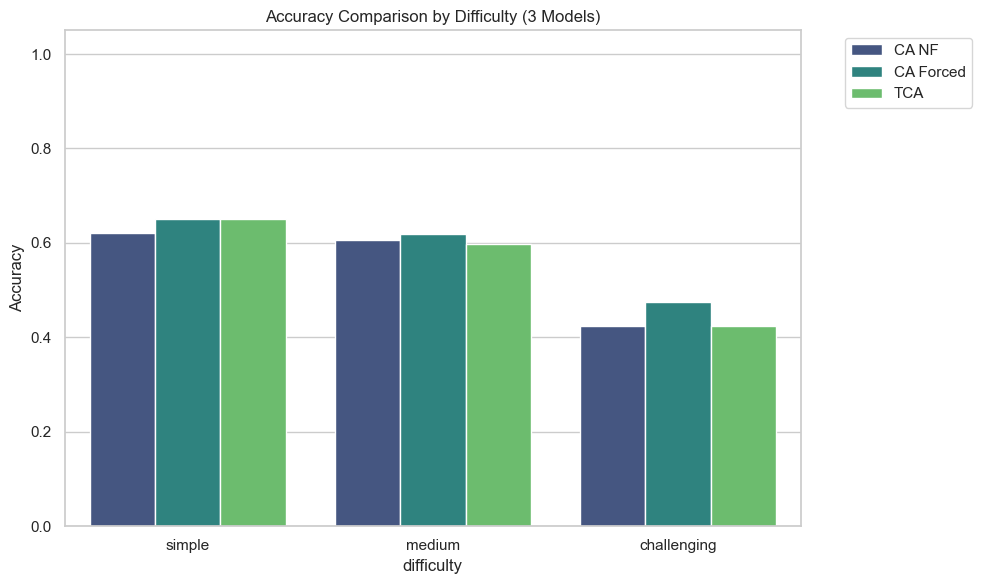

In [17]:
melted = df.melt(
    id_vars=['difficulty'], 
    value_vars=['execution_accuracy_nf', 'execution_accuracy_forced', 'execution_accuracy_agent'],
    var_name='Model', value_name='Accuracy'
)
melted['Model'] = melted['Model'].replace(model_map)

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='difficulty', y='Accuracy', hue='Model', 
            order=diff_order, palette="viridis", errorbar=None)
plt.title("Accuracy Comparison by Difficulty (3 Models)")
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
save_plot("accuracy_comparison_by_difficulty")
plt.show()

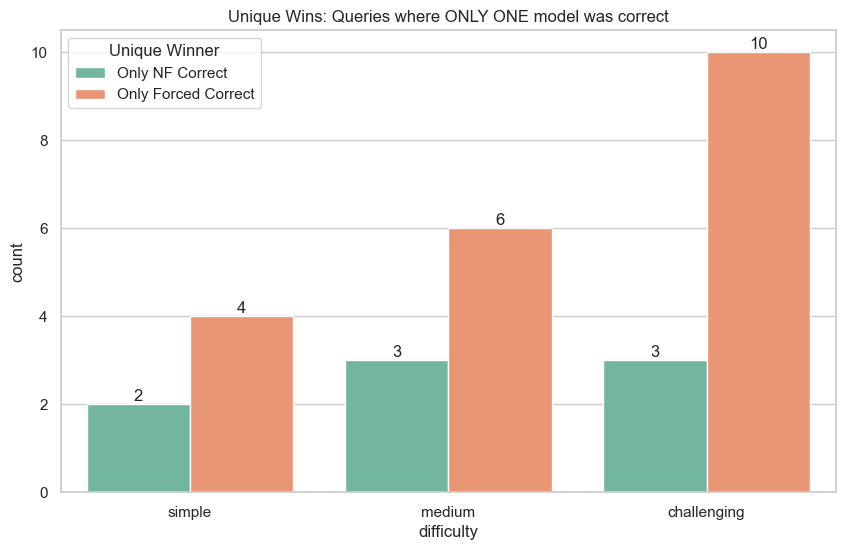

In [18]:
def classify_unique_wins(row):
    if row['is_correct_nf'] and not row['is_correct_forced'] and not row['is_correct_agent']:
        return 'Only NF Correct'
    elif not row['is_correct_nf'] and row['is_correct_forced'] and not row['is_correct_agent']:
        return 'Only Forced Correct'
    return 'Mixed/Shared'

df['outcome_3way'] = df.apply(classify_unique_wins, axis=1)

unique_wins = df[df['outcome_3way'].str.startswith('Only')]

if not unique_wins.empty:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=unique_wins, x='difficulty', hue='outcome_3way', 
                        order=diff_order, palette="Set2")
    plt.title("Unique Wins: Queries where ONLY ONE model was correct")
    for container in ax.containers: ax.bar_label(container)
    plt.legend(title='Unique Winner')
    save_plot("unique_wins_by_difficulty")
    plt.show()
else:
    print("Nessun caso in cui un solo modello ha risposto correttamente (tutte vittorie condivise o errori condivisi).")

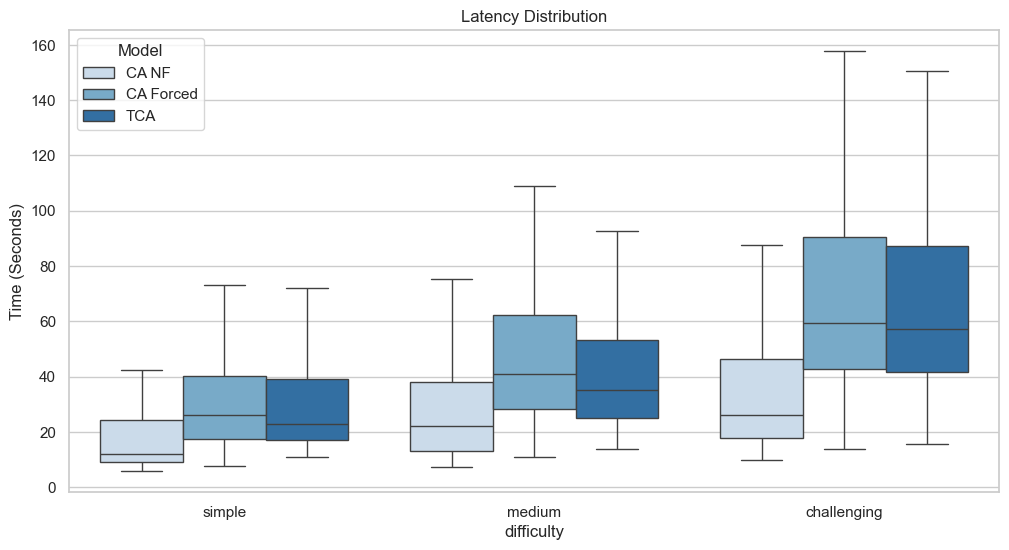

Average Latency (Seconds):
             latency_nf  latency_forced  latency_agent
difficulty                                            
simple        19.173700       32.164900      32.858400
medium        29.574408       52.473618      43.704737
challenging   37.357179       74.422244      75.038269


In [19]:
melted_lat = df.melt(
    id_vars=['difficulty'], 
    value_vars=['latency_nf', 'latency_forced', 'latency_agent'],
    var_name='Model', value_name='Seconds'
)
melted_lat['Model'] = melted_lat['Model'].replace(model_map)

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_lat, x='difficulty', y='Seconds', hue='Model', 
            order=diff_order, palette="Blues", showfliers=False) 
plt.title("Latency Distribution")
plt.ylabel("Time (Seconds)")
save_plot("latency_distribution_by_difficulty")
plt.show()

print("Average Latency (Seconds):")

print(df.groupby('difficulty')[['latency_nf', 'latency_forced', 'latency_agent']].mean().reindex(diff_order))



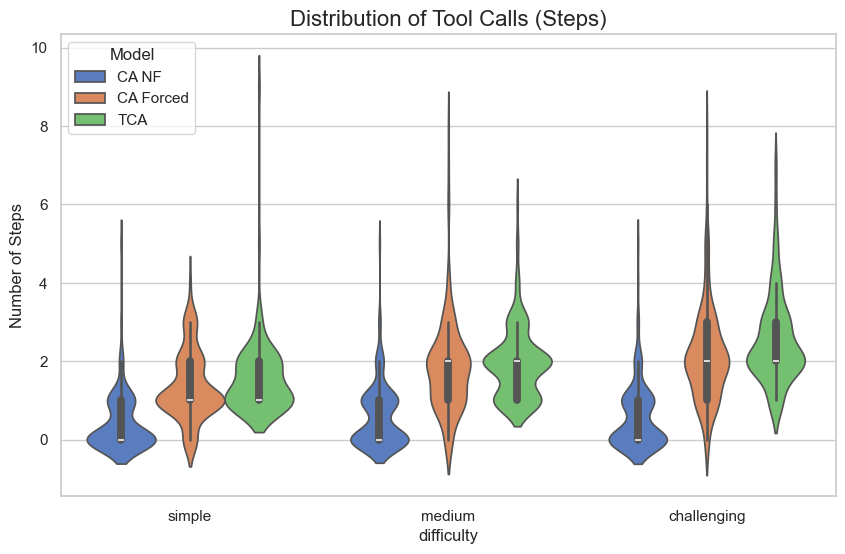

In [20]:
melted_tools = df.melt(
    id_vars=['difficulty'], 
    value_vars=['tool_call_count_nf', 'tool_call_count_forced', 'tool_call_count_agent'],
    var_name='Model', value_name='Steps'
)
melted_tools['Model'] = melted_tools['Model'].replace(model_map)

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=melted_tools, 
    x='difficulty', 
    y='Steps', 
    hue='Model', 
    order=diff_order, 
    palette="muted"
)
plt.title("Distribution of Tool Calls (Steps)", fontsize=16)
plt.ylabel("Number of Steps")
plt.show()

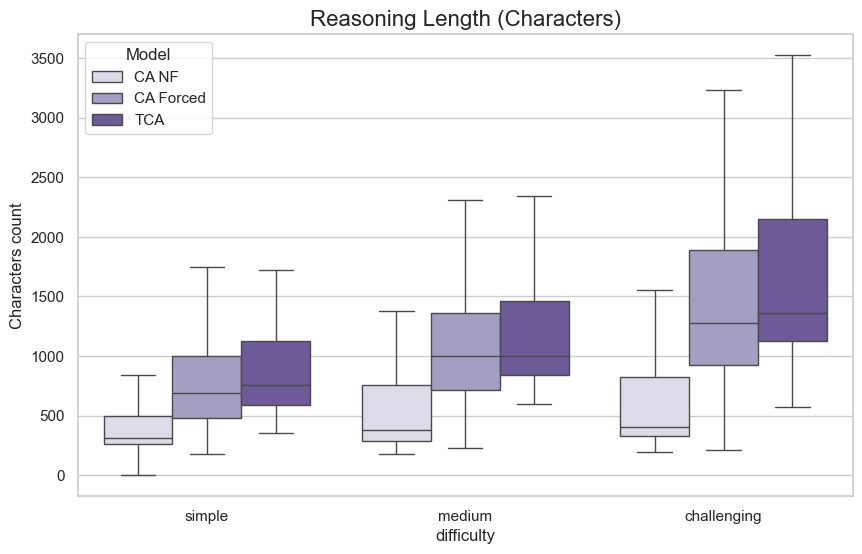

In [21]:
melted_len = df.melt(
    id_vars=['difficulty'], 
    value_vars=['reasoning_len_nf', 'reasoning_len_forced', 'reasoning_len_agent'],
    var_name='Model', value_name='Chars'
)
melted_len['Model'] = melted_len['Model'].replace(model_map)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=melted_len, 
    x='difficulty', 
    y='Chars', 
    hue='Model', 
    order=diff_order, 
    palette="Purples", 
    showfliers=False
)
plt.title("Reasoning Length (Characters)", fontsize=16)
plt.ylabel("Characters count")
plt.show()

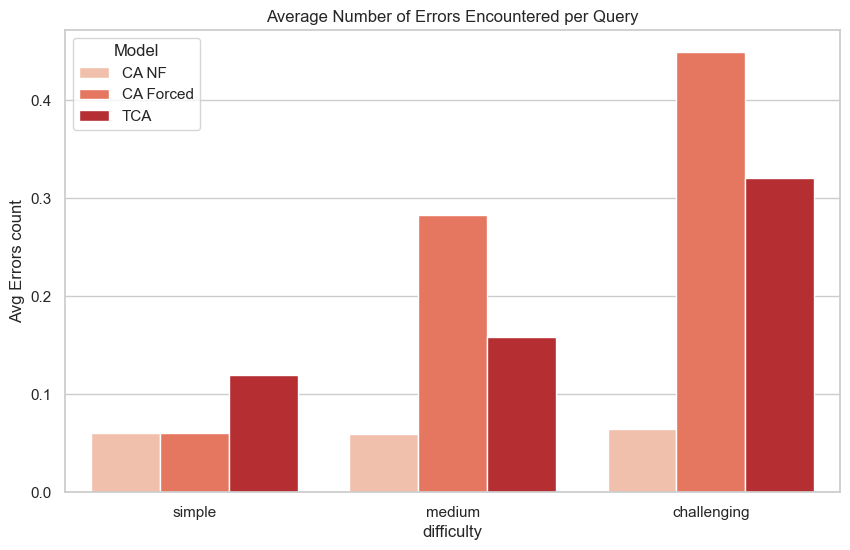

In [22]:
avg_errors = df.groupby('difficulty')[['error_count_nf', 'error_count_forced', 'error_count_agent']].mean().reset_index()

melted_err = avg_errors.melt(
    id_vars='difficulty', 
    var_name='Model', value_name='Avg_Errors'
)
melted_err['Model'] = melted_err['Model'].replace(model_map)

plt.figure(figsize=(10, 6))
sns.barplot(data=melted_err, x='difficulty', y='Avg_Errors', hue='Model', 
            order=diff_order, palette="Reds")
plt.title("Average Number of Errors Encountered per Query")
plt.ylabel("Avg Errors count")
save_plot("average_errors_by_difficulty")
plt.show()

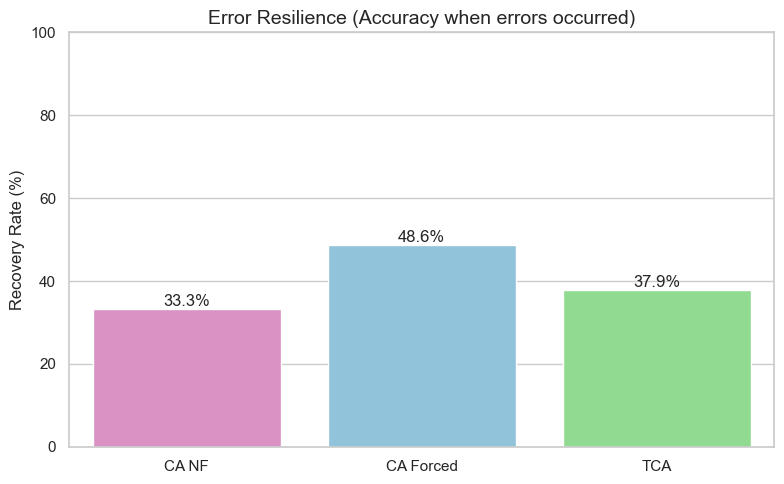

In [23]:
def get_recovery_rate(dataset, err_col, acc_col):
    subset = dataset[dataset[err_col] > 0]
    if subset.empty: return 0
    return subset[acc_col].mean() * 100

rec_nf = get_recovery_rate(df, 'error_count_nf', 'execution_accuracy_nf')
rec_forced = get_recovery_rate(df, 'error_count_forced', 'execution_accuracy_forced')
rec_agent = get_recovery_rate(df, 'error_count_agent', 'execution_accuracy_agent')

resilience_data = pd.DataFrame({
    'Model': ['CA NF', 'CA Forced', 'TCA'],
    'Recovery Rate (%)': [rec_nf, rec_forced, rec_agent]
})

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=resilience_data,
    x='Model',
    y='Recovery Rate (%)',
    hue='Model',
    palette=["#e685c7", "#85c7e6", "#85e685"],
    legend=False
)

plt.title("Error Resilience (Accuracy when errors occurred)", fontsize=14)
plt.ylim(0, 100)
plt.ylabel("Recovery Rate (%)")
plt.xlabel("")

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f"{p.get_height():.1f}%",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', fontsize=12
        )

plt.tight_layout()
plt.show()